#Initialization of the kaggle and the files#

In [44]:
# reading in the data via the Kaggle API

# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [45]:
# install Kaggle
! pip install kaggle

Log into your Kaggle account, go to Account > API > Create new API token. You will obtain a kaggle.json file, which you save on your Google Drive directy in my drive.

In [46]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [47]:
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [48]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

detecting-french-texts-difficulty-level-2023.zip: Skipping, found more recently modified local copy (use --force to force download)


# Begining of the model#

## Imports##

######For this model we decide to use the LSTM model. I discover this model in a Information Security and Privacy course. This model was use for human recognition activities. I decided to do some research about this model and I decided to try this one for this problem.

#####LSTM model improve in terms of efficiency by memorizing the important informations. He will ignore the no important information and take in consideration the important information.  

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold


df = pd.read_csv('training_data.csv', index_col = 'id')
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col = 'id')

In [50]:
df

,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1
...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2
4796,Il avait une de ces pâleurs splendides qui don...,C1
4797,"Et le premier samedi de chaque mois, venez ren...",A2


In [51]:
X = df['sentence']
Y = df['difficulty']

#####In this part we tokenize our sentences and encode what we want to predict the difficulty

In [52]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['sentence'])

X_train = tokenizer.texts_to_sequences(df['sentence'])
X_train_padded = pad_sequences(X_train, maxlen=100)

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(df['difficulty'])
Y_categorical = to_categorical(Y_encoded)

#####After some data transformation we can construct our model. And as all our models we split 20% of our data. Here we decide to use the k flods because without the folds we have a model with metrics arround 70% but a prediction on the unlabelled dataset arround 45%. So we decide to use the folds to be sure that our models take into consideration all kind of differents classes (A1,A2...)

In [53]:
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

scores = []

for train_index, test_index in kfold.split(X_train_padded):
    X_train_fold, X_val_fold = X_train_padded[train_index], X_train_padded[test_index]
    Y_train_fold, Y_val_fold = Y_categorical[train_index], Y_categorical[test_index]

    Y_true_classes = np.argmax(Y_val_fold, axis=1)

    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=100, input_length=100))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(6, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.fit(X_train_fold, Y_train_fold, batch_size=64, epochs=5)

    Y_pred = model.predict(X_val_fold)
    Y_pred_classes= np.argmax(Y_pred, axis=1)

    accuracy = accuracy_score(Y_true_classes, Y_pred_classes)
    precision = precision_score(Y_true_classes, Y_pred_classes, average='macro')
    recall = recall_score(Y_true_classes, Y_pred_classes, average='macro')
    f1 = f1_score(Y_true_classes, Y_pred_classes, average='macro')

    scores.append((accuracy, precision, recall, f1))



Epoch 1/5
60/60 [==============================] - 36s 564ms/step - loss: 1.6373 - accuracy: 0.2956
Epoch 2/5
60/60 [==============================] - 19s 315ms/step - loss: 1.4112 - accuracy: 0.3909
Epoch 3/5
60/60 [==============================] - 18s 294ms/step - loss: 1.1926 - accuracy: 0.4956
Epoch 4/5
60/60 [==============================] - 17s 292ms/step - loss: 1.0045 - accuracy: 0.5987
Epoch 5/5
30/30 [==============================] - 1s 32ms/step
Epoch 1/5
60/60 [==============================] - 20s 295ms/step - loss: 1.6442 - accuracy: 0.2810
Epoch 2/5
60/60 [==============================] - 18s 293ms/step - loss: 1.4163 - accuracy: 0.3753
Epoch 3/5
60/60 [==============================] - 18s 293ms/step - loss: 1.1935 - accuracy: 0.5016
Epoch 4/5
60/60 [==============================] - 17s 292ms/step - loss: 0.9701 - accuracy: 0.6112
Epoch 5/5
30/30 [==============================] - 1s 31ms/step
Epoch 1/5
60/60 [==============================] - 20s 294ms/step - loss

##Metrics

#####Here we calculate some metrics to see how good our model is

In [54]:
mean_scores = np.mean(scores, axis=0)
print(f'Mean scores on {num_folds} folds: Accuracy: {mean_scores[0]}, Precision: {mean_scores[1]}, Recall: {mean_scores[2]}, F1 Score: {mean_scores[3]}')


Mean scores on 5 folds: Accuracy: 0.44333333333333336, Precision: 0.44522952807445393, Recall: 0.4428534738552405, F1 Score: 0.43976167686760037


In [55]:
Y_pred_classes

array([4, 1, 2, 0, 1, 2, 4, 5, 3, 0, 3, 0, 4, 5, 2, 0, 5, 3, 0, 2, 4, 4,
       3, 5, 1, 3, 0, 5, 4, 3, 1, 4, 4, 2, 0, 2, 4, 2, 4, 0, 5, 3, 2, 5,
       1, 1, 0, 2, 3, 0, 4, 3, 5, 4, 0, 5, 5, 3, 0, 1, 4, 3, 5, 0, 0, 3,
       0, 5, 5, 1, 5, 0, 0, 3, 0, 4, 3, 2, 5, 3, 2, 3, 4, 0, 2, 4, 3, 0,
       1, 4, 4, 3, 1, 1, 4, 0, 0, 5, 1, 0, 0, 0, 4, 0, 4, 5, 1, 3, 3, 3,
       4, 4, 1, 3, 1, 5, 4, 5, 4, 1, 0, 3, 0, 0, 0, 3, 0, 2, 0, 5, 4, 0,
       1, 4, 0, 1, 5, 4, 4, 3, 4, 5, 2, 3, 0, 4, 1, 4, 3, 4, 4, 3, 0, 4,
       3, 5, 0, 0, 5, 3, 1, 5, 2, 2, 4, 3, 1, 1, 4, 4, 0, 1, 1, 0, 1, 3,
       0, 0, 5, 4, 3, 3, 0, 3, 1, 1, 1, 4, 4, 2, 3, 0, 1, 4, 1, 2, 4, 0,
       0, 0, 5, 3, 0, 0, 2, 3, 5, 0, 5, 3, 2, 3, 3, 5, 3, 2, 2, 2, 4, 1,
       0, 3, 1, 4, 1, 1, 2, 1, 4, 1, 4, 2, 5, 4, 3, 3, 3, 0, 3, 4, 1, 2,
       3, 3, 3, 4, 0, 0, 3, 0, 2, 0, 0, 3, 4, 1, 5, 1, 2, 4, 3, 4, 5, 3,
       5, 4, 0, 0, 0, 4, 2, 1, 3, 0, 1, 3, 0, 3, 2, 3, 1, 3, 5, 4, 1, 4,
       5, 4, 0, 0, 0, 0, 4, 5, 0, 5, 4, 0, 5, 0, 4,

##Predictions

#####And then we use our model to predict our unlabelled data

In [56]:

X_unlabelled = tokenizer.texts_to_sequences(df_pred['sentence'])
X_unlabelled_padded = pad_sequences(X_unlabelled, maxlen=100)

predictions = model.predict(X_unlabelled_padded)

predicted_classes = np.argmax(predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)


38/38 [==============================] - 2s 35ms/step


In [57]:

df_pred['predicted_difficulty'] = predicted_labels


df_pred


,sentence,predicted_difficulty
id,,
0,Nous dûmes nous excuser des propos que nous eû...,C2
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,A2
2,"Et, paradoxalement, boire froid n'est pas la b...",A2
3,"Ce n'est pas étonnant, car c'est une saison my...",A2
4,"Le corps de Golo lui-même, d'une essence aussi...",C2
...,...,...
1195,C'est un phénomène qui trouve une accélération...,B1
1196,Je vais parler au serveur et voir si on peut d...,A2
1197,Il n'était pas comme tant de gens qui par pare...,C2


# This is how to submit a pd file with predictions
### for the example we will submit a file where only A1 is given as a prediction

In [58]:
df_sub=df_pred[['predicted_difficulty']]
df_sub.to_csv('submission.csv')

In [59]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

100% 8.31k/8.31k [00:01<00:00, 4.33kB/s]
Successfully submitted to Detecting the difficulty level of French texts

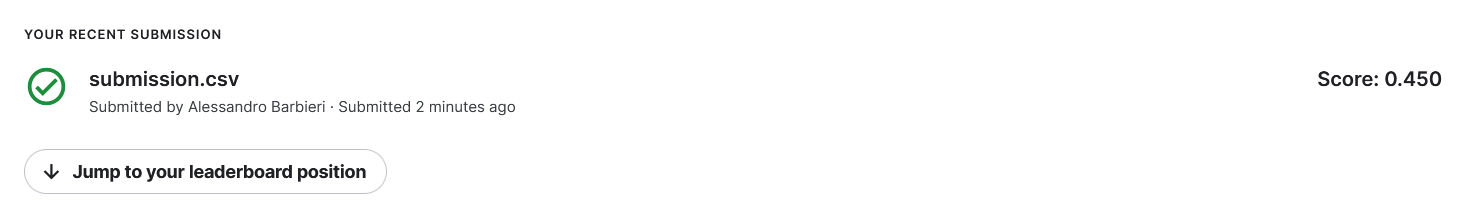